In [ ]:
!pip install import-ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# importing the tools to call google drive
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb

In [ ]:
# mount our directory
mount='/content/gdrive'
drive.mount(mount, force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Switch to the directory on the VM for our purposes
drive_root=mount + '/My Drive/Colab Notebooks/Thesis'
%cd $drive_root
%pwd

/content/gdrive/My Drive/Colab Notebooks/Thesis


'/content/gdrive/My Drive/Colab Notebooks/Thesis'

In [ ]:
import Pitch_Plot
import data
from data import obtain_seasons,fetch_url,Game
from Pitch_Plot import pitchplot

importing Jupyter notebook from Pitch_Plot.ipynb
importing Jupyter notebook from data.ipynb


In [ ]:
laliga = obtain_seasons(11)

Getting season 2020/2021...
Getting season 2019/2020...
Getting season 2018/2019...
Getting season 2017/2018...
Getting season 2016/2017...
Getting season 2015/2016...
Getting season 2014/2015...
Getting season 2013/2014...
Getting season 2012/2013...
Getting season 2011/2012...
Getting season 2010/2011...
Getting season 2009/2010...
Getting season 2008/2009...
Getting season 2007/2008...
Getting season 2006/2007...
Getting season 2005/2006...
Getting season 2004/2005...
Done


In [ ]:
laliga

In [ ]:
def player_density(x_shot, y_shot, x_player, y_player):
    """
    This confirms whether a player is between the shot taker and the goal.
    
    Arguments:
    x_shot    x-location of shot
    y_shot    y-location of shot
    x_player  x-location of player
    y_player  y-location of player    
    """
    x_difference = x_player - x_shot
    y_difference = y_player - y_shot
    
    if 120 - x_shot == 0:
        return False
    
    slope_1 = (36 - y_shot) / (120 - x_shot)
    slope_2 = (44 - y_shot) / (120 - x_shot) 
                    
    return (x_difference >= 0) and ((y_shot + slope_1 * x_difference) < y_player < (y_shot + slope_2 * x_difference))


def freeze_frame(game_json, shot_id):
    """
    This function plots the location of the shot taker and the other players present on the pitch along with the goalkeeper.
    
    Arguments:
    game_json : name of the game file
    shot_id: id of the shot    
    """
    pitchplot()
    gk_x = 120
    gk_y = 40
    player_pos_list_x = []
    player_pos_list_y = []
    player_name = []
    team_name = []
    x_shot = 0
    y_shot = 0
    
    for events in game_json:
        if events['id'] == shot_id:
            x_shot = events['location'][0]
            y_shot = events['location'][1]
        
            if "freeze_frame" in events["shot"]:
                for players in events['shot']['freeze_frame']:
                    if (players['teammate'] == False):
                        player_pos_list_x.append(players['location'][0])
                        player_pos_list_y.append(players['location'][1])
                        player_name.append(events['player']['name'])
                        team_name.append(events['possession_team']['name'])
                        
                    if ((players['position']['name'] == 'Goalkeeper') and (players['teammate'] == False)):
                        gk_x = players['location'][0]
                        gk_y = players['location'][1]                      
    plt.scatter(player_pos_list_x, player_pos_list_y, color = 'black')
    plt.scatter(x_shot, y_shot, s=200)
    plt.scatter(gk_x, gk_y, s=100, color='red')
    plt.plot([x_shot, 120], [y_shot,36], color = 'red', linestyle = 'dashed')
    plt.plot([x_shot, 120], [y_shot,44], color = 'red', linestyle = 'dashed')
    plt.title(player_name[0] + '\n' + team_name[0], fontsize = 30)

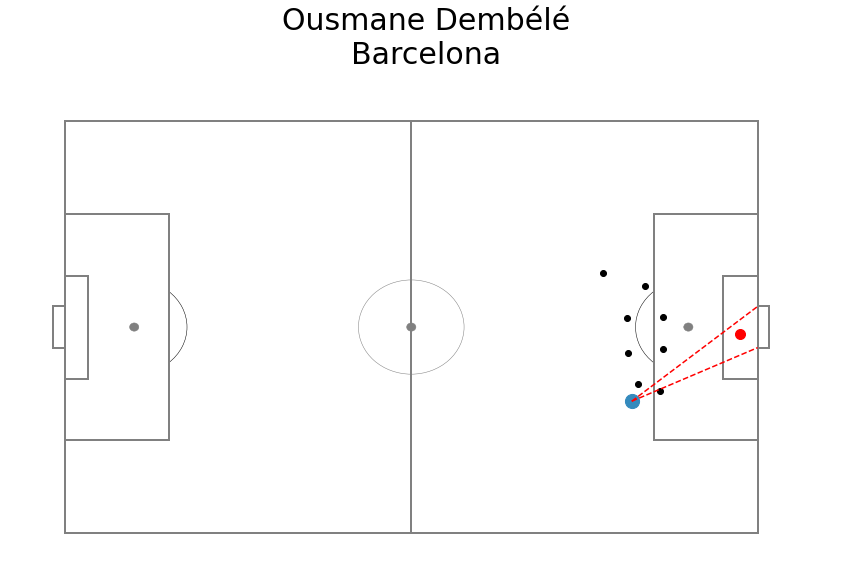

In [ ]:
freeze_frame(laliga["2020/2021"]['3764661'].json_file, "7cd59690-adb1-4b18-9657-9b40b5c3006c")

In [ ]:
def pass_type(id, match):
  """
    This function takes the id of the goal assist and returns which type of pass it is.
    
    Arguments:
    id: id of the goal assist
    match: details of the match file   
  """
  key_pass_type = ''
  for events in match:
    if events['id'] == id:
      key_pass_type = events['pass']['height']['name']
      break
  return key_pass_type

In [ ]:
key_pass = []
key_pass_type = []
for events in laliga["2020/2021"]['3764661'].json_file:
  if events['type']['name'] == 'Shot':
    try:
      key_pass.append(events['shot']['key_pass_id'])
      key_pass_type.append(pass_type(events['shot']['key_pass_id'], laliga["2020/2021"]['3764661'].json_file))
    except KeyError:
      key_pass.append('No Pass')
      key_pass_type.append('None')

In [ ]:
key_pass_type

['Low Pass',
 'Ground Pass',
 'Ground Pass',
 'High Pass',
 'Ground Pass',
 'Ground Pass',
 'High Pass',
 'Ground Pass',
 'Ground Pass',
 'Ground Pass',
 'Ground Pass',
 'Low Pass',
 'None',
 'None',
 'Ground Pass',
 'Ground Pass',
 'Ground Pass',
 'None',
 'Low Pass',
 'Low Pass',
 'Ground Pass']

In [ ]:
def obtain_shots_match(match):
    """
    Function which parses through a game json file and returna a data frame containing all shots taken in that game with several features 
    related to that shot
    
    Arguments
    game_json - details of the json file
    """
    
    #features for each shot, which will be the columns of our data frame
    shot_id_list = []
    x_start_location_list = []
    y_start_location_list = []
    play_pattern_list = []
    duration_list = []
    outcome_list = []
    technique_list = []
    type_shot_list = []
    first_time_list = []
    body_part_name = []
    x_gk_pos_list = []
    y_gk_pos_list = []
    num_opponents_5_yards_list = []
    num_opponents_between_goal_list = []
    statsbomb_xg = [] #to compare to my model
    team_name = []
    player_name = []
    key_pass_id = []
    key_pass_type = []
    #-------------------------#

    for events in match:
    
        if events['type']['name'] == 'Shot':
    
            #get data immediately needed features
            shot_id = events['id']
            x_start_location = events['location'][0]
            y_start_location = events['location'][1]
            play_pattern = events['play_pattern']['name']
            duration = events['duration']
            outcome = events['shot']['outcome']['name'] 
            technique = events['shot']['technique']['name']
            type_shot = events['shot']['type']['name']
            xg = events['shot']['statsbomb_xg']
            body_part = events['shot']['body_part']['name']
            team = events['possession_team']['name']
            player1 = events['player']['name']
            pass_id = ''
            type_pass = ''

            try:
                pass_id = events['shot']['key_pass_id']
                type_pass = pass_type(pass_id,match)

            except KeyError:
                pass_id = 'No Pass'
                type_pass = 'None'

            #check if json shot has a first_time attribute, if not set first_time to False
            if 'first_time' in events['shot']:
                first_time = events['shot']['first_time']

            else:
                first_time = False
            
            #check if shot has a freeze_frame dictionary
            if "freeze_frame" in events["shot"]:
                
                num_opponents_5_yards = 0
                num_opponents_between_goal = 0
                
                for player in events["shot"]["freeze_frame"]:
                    x_player = player['location'][0]
                    y_player = player['location'][1]
                    
                    #count how many opponents were within 5 yards of player when shot was taken
                    if ((x_start_location - x_player)**2 + (y_start_location - y_player)**2) <= 25 and (player['teammate'] == False):
                        if (player['position']['name'] != 'Goalkeeper'):
                            num_opponents_5_yards += 1
                    
                    #count how many opponents were between shot and goal
                    if (player['teammate'] == False) and (player['position']['name'] != 'Goalkeeper'):
                        if player_density(x_start_location, y_start_location, x_player, y_player):
                            num_opponents_between_goal += 1
                    
                    #get position of opponent's goalkeeper 
                    if ((player['position']['name'] == 'Goalkeeper') and (player['teammate'] == False)):
                        x_gk_pos = player['location'][0]
                        y_gk_pos = player['location'][1]
            
            #if there is no freeze frame, assume goalkeeper is at center of goal, and 0 opponenets around shot location
            else:
                num_opponents_between_goal = 0
                num_opponents_5_yards = 0
                x_gk_pos = 120
                y_gk_pos = 40            
            
            try:
                x_gk_pos_list.append(x_gk_pos)
                y_gk_pos_list.append(y_gk_pos)

            except UnboundLocalError:
                x_gk_pos_list.append(np.nan)
                y_gk_pos_list.append(np.nan)
            
            
            #append data on shot to relevant list (column)
            shot_id_list.append(shot_id)
            play_pattern_list.append(play_pattern)
            x_start_location_list.append(x_start_location)
            y_start_location_list.append(y_start_location)
            duration_list.append(duration)
            outcome_list.append(outcome)
            technique_list.append(technique)
            first_time_list.append(first_time)
            type_shot_list.append(type_shot)
            body_part_name.append(body_part)
            num_opponents_5_yards_list.append(num_opponents_5_yards)
            num_opponents_between_goal_list.append(num_opponents_between_goal)
            statsbomb_xg.append(xg)
            team_name.append(team)
            player_name.append(player1)
            key_pass_id.append(pass_id)
            key_pass_type.append(type_pass)

    #create a data frame with the features
    shot_df = pd.DataFrame({
                       "shot id" : shot_id_list,
                       "play pattern" : play_pattern_list, 
                       "x location shot" : x_start_location_list, 
                       "y location shot" : y_start_location_list,
                       "duration" : duration_list, 
                       "outcome" : outcome_list, 
                       "technique used" : technique_list, 
                       "first time" : first_time_list,
                       "x gk location" : x_gk_pos_list,
                       "y gk location" : y_gk_pos_list,
                       "body part" : body_part_name,
                       "type of shot" : type_shot_list,
                       "Number of opponents in 5 yards" : num_opponents_5_yards_list,
                       "Players between goal" : num_opponents_between_goal_list,
                       "player name" : player_name,
                       "Team Name" : team_name,
                       "official xg" : statsbomb_xg,
                       "Pass id": key_pass_id,
                       "Pass Type": key_pass_type
                       })
    
    return shot_df

In [ ]:
def obtain_season_shots(season):
    """
    Takes a dictionary whichs maps game ids to Game objects, and calls obtain_shots_match() on each one.
    
    Arguments:
    season: dictionary which has game file names (string, as specified by statsbomb) to objects (defined above)
    """
    total_shot_df = pd.DataFrame()
    
    for keys, values in season.items():
        shot_df = obtain_shots_match(values.json_file)
        shot_df["game_id"] = keys
        total_shot_df = total_shot_df.append(shot_df)
        
    return total_shot_df


def obtain_all_shots(league):
    """
    Takes the original data from statsbomb and passes it to obtain_season_shots to process and procure football shots.
    
    Arguments:
    league - The dictionary that iterates season names to a further dictionary. The latter iterates 
    match ids (as defined by statsbomb) to all events in the matches.
    """
    total_shot_df = pd.DataFrame()
    
    for keys, values in league.items():
        shot_df = obtain_season_shots(values)
        shot_df["season_id"] = keys
        total_shot_df = total_shot_df.append(shot_df)
        print("Obtaining shots for " + keys)
    
    print("Done.")
    
    return total_shot_df

In [ ]:
laliga_shots = obtain_all_shots(laliga)

Obtaining shots for 2020/2021
Obtaining shots for 2019/2020
Obtaining shots for 2018/2019
Obtaining shots for 2017/2018
Obtaining shots for 2016/2017
Obtaining shots for 2015/2016
Obtaining shots for 2014/2015
Obtaining shots for 2013/2014
Obtaining shots for 2012/2013
Obtaining shots for 2011/2012
Obtaining shots for 2010/2011
Obtaining shots for 2009/2010
Obtaining shots for 2008/2009
Obtaining shots for 2007/2008
Obtaining shots for 2006/2007
Obtaining shots for 2005/2006
Obtaining shots for 2004/2005
Done.


In [ ]:
laliga_shots

,shot id,play pattern,x location shot,y location shot,duration,outcome,technique used,first time,x gk location,y gk location,...,type of shot,Number of opponents in 5 yards,Players between goal,player name,Team Name,official xg,Pass id,Pass Type,game_id,season_id
0,859f0f2d-6b33-49a3-9397-64d2ab927a73,From Counter,107.1,57.2,0.615658,Saved,Normal,False,117.4,44.0,...,Open Play,2,0,Rafael Mir Vicente,Huesca,0.029275,e040e36e-15d7-42f5-8d9b-378139572208,Low Pass,3773369,2020/2021
1,7a1b1dcb-4e09-4bfa-9827-9d81b6944bc5,From Throw In,99.3,55.1,0.762260,Saved,Normal,False,117.9,41.9,...,Open Play,1,0,Sergino Dest,Barcelona,0.036545,No Pass,None,3773369,2020/2021
2,5078ef4c-43ea-4e5e-90cc-8c288349b3e3,Regular Play,99.4,33.0,1.847193,Goal,Normal,False,117.5,38.5,...,Open Play,3,1,Lionel Andrés Messi Cuccittini,Barcelona,0.041210,80c324ab-5504-4eba-9f9b-0c8ee58d5f64,Ground Pass,3773369,2020/2021
3,3b87f877-45b9-425c-8d0c-035975f7f0cf,From Throw In,108.0,34.2,0.914051,Off T,Normal,False,117.4,38.5,...,Open Play,5,1,Lionel Andrés Messi Cuccittini,Barcelona,0.136125,bd61aa8e-9621-4bd1-be83-b2bbb9dfee4f,Ground Pass,3773369,2020/2021
4,06c3d431-8ac3-43fa-9585-d9689f7a44f3,From Throw In,104.1,43.0,0.642854,Saved,Normal,False,117.1,41.4,...,Open Play,3,1,Pablo Maffeo Becerra,Huesca,0.095665,b8f27912-bac9-4950-8086-33404437d953,Ground Pass,3773369,2020/2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,4468faac-ae6a-4637-928b-fc7dd448411b,From Free Kick,91.1,47.1,1.622413,Post,Normal,False,118.4,40.8,...,Free Kick,0,4,Giovanni van Bronckhorst,Barcelona,0.049559,No Pass,None,68353,2004/2005
21,5f613006-c00e-4581-882c-a7a81978ebf0,From Throw In,103.7,33.6,1.070861,Off T,Half Volley,False,119.5,39.8,...,Open Play,3,0,Ferrán Corominas Telechea,Espanyol,0.057103,No Pass,None,68353,2004/2005
22,717c9351-6eff-4f71-969a-e25bab5bfcb6,From Throw In,107.9,37.0,0.701300,Saved,Volley,True,119.2,39.6,...,Open Play,2,1,Mauricio Roberto Pochettino Trossero,Espanyol,0.113389,dbaca88f-32d3-4abe-a37d-4fceb67a4302,Low Pass,68353,2004/2005
23,0c914938-af14-479e-8043-8e4bfdfd474d,From Throw In,117.8,43.9,1.256200,Post,Normal,False,118.9,43.3,...,Open Play,1,0,Ferrán Corominas Telechea,Espanyol,0.415576,No Pass,None,68353,2004/2005


In [ ]:
laliga_shots['distance_from_goalpost_a'] = np.sqrt((laliga_shots['x location shot']-120)**2+(laliga_shots['y location shot']-36)**2)
laliga_shots['distance_from_goalpost_b'] = np.sqrt((laliga_shots['x location shot']-120)**2+(laliga_shots['y location shot']-44)**2)

laliga_shots['shot_angle'] = np.arccos((laliga_shots['distance_from_goalpost_a']**2+laliga_shots['distance_from_goalpost_b']**2-64)/(2*laliga_shots['distance_from_goalpost_a']*laliga_shots['distance_from_goalpost_b']))
laliga_shots['shot_angle'] = np.degrees(laliga_shots['shot_angle'])
laliga_shots['shot_angle'] = round(laliga_shots['shot_angle'],1)

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
laliga_shots

,shot id,play pattern,x location shot,y location shot,duration,outcome,technique used,first time,x gk location,y gk location,...,player name,Team Name,official xg,Pass id,Pass Type,game_id,season_id,distance_from_goalpost_a,distance_from_goalpost_b,shot_angle
0,859f0f2d-6b33-49a3-9397-64d2ab927a73,From Counter,107.1,57.2,0.615658,Saved,Normal,False,117.4,44.0,...,Rafael Mir Vicente,Huesca,0.029275,e040e36e-15d7-42f5-8d9b-378139572208,Low Pass,3773369,2020/2021,24.816325,18.456706,13.0
1,7a1b1dcb-4e09-4bfa-9827-9d81b6944bc5,From Throw In,99.3,55.1,0.762260,Saved,Normal,False,117.9,41.9,...,Sergino Dest,Barcelona,0.036545,No Pass,None,3773369,2020/2021,28.165582,23.488295,14.5
2,5078ef4c-43ea-4e5e-90cc-8c288349b3e3,Regular Play,99.4,33.0,1.847193,Goal,Normal,False,117.5,38.5,...,Lionel Andrés Messi Cuccittini,Barcelona,0.041210,80c324ab-5504-4eba-9f9b-0c8ee58d5f64,Ground Pass,3773369,2020/2021,20.817300,23.352944,19.8
3,3b87f877-45b9-425c-8d0c-035975f7f0cf,From Throw In,108.0,34.2,0.914051,Off T,Normal,False,117.4,38.5,...,Lionel Andrés Messi Cuccittini,Barcelona,0.136125,bd61aa8e-9621-4bd1-be83-b2bbb9dfee4f,Ground Pass,3773369,2020/2021,12.134249,15.493224,30.7
4,06c3d431-8ac3-43fa-9585-d9689f7a44f3,From Throw In,104.1,43.0,0.642854,Saved,Normal,False,117.1,41.4,...,Pablo Maffeo Becerra,Huesca,0.095665,b8f27912-bac9-4950-8086-33404437d953,Ground Pass,3773369,2020/2021,17.372680,15.931416,27.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,4468faac-ae6a-4637-928b-fc7dd448411b,From Free Kick,91.1,47.1,1.622413,Post,Normal,False,118.4,40.8,...,Giovanni van Bronckhorst,Barcelona,0.049559,No Pass,None,68353,2004/2005,30.958359,29.065787,14.9
21,5f613006-c00e-4581-882c-a7a81978ebf0,From Throw In,103.7,33.6,1.070861,Off T,Half Volley,False,119.5,39.8,...,Ferrán Corominas Telechea,Espanyol,0.057103,No Pass,None,68353,2004/2005,16.475740,19.335201,24.2
22,717c9351-6eff-4f71-969a-e25bab5bfcb6,From Throw In,107.9,37.0,0.701300,Saved,Volley,True,119.2,39.6,...,Mauricio Roberto Pochettino Trossero,Espanyol,0.113389,dbaca88f-32d3-4abe-a37d-4fceb67a4302,Low Pass,68353,2004/2005,12.141252,13.978913,34.8
23,0c914938-af14-479e-8043-8e4bfdfd474d,From Throw In,117.8,43.9,1.256200,Post,Normal,False,118.9,43.3,...,Ferrán Corominas Telechea,Espanyol,0.415576,No Pass,None,68353,2004/2005,8.200610,2.202272,77.0


In [ ]:
df = pd.read_pickle('./data.pkl')

In [ ]:
df

,shot id,play pattern,x location shot,y location shot,duration,outcome,technique used,first time,x gk location,y gk location,...,player name,Team Name,official xg,Pass id,Pass Type,game_id,season_id,distance_from_goalpost_a,distance_from_goalpost_b,shot_angle
0,56deeffa-ff55-429e-91df-41f237a3ebac,Regular Play,103.7,46.3,0.909600,Saved,Normal,True,116.0,43.0,...,Samantha May Kerr,Australia Women's,0.174474,448cb3aa-ee0b-4829-a7d4-bdef6dfda5bd,Ground Pass,68311,2019,19.281597,16.461470,24.3
1,00d9c066-1078-4e1c-8c7f-2ca299e3a5f0,From Free Kick,107.4,37.4,1.033500,Goal,Normal,False,118.3,39.9,...,Samantha May Kerr,Australia Women's,0.028797,f5d55ee4-2db3-4604-b9fa-8bd0645fdc4b,High Pass,68311,2019,12.677539,14.223924,34.0
2,48706448-928f-4721-96ec-2b813f448937,Regular Play,108.5,48.1,1.391602,Off T,Normal,False,118.9,42.8,...,Samantha May Kerr,Australia Women's,0.027564,13eaef4e-1393-4b99-b94d-d60c35070713,High Pass,68311,2019,16.693112,12.209013,26.8
3,718f8a06-078c-489e-9423-63d414be5e43,From Throw In,106.0,43.7,1.154700,Saved,Normal,False,118.9,42.1,...,Samantha May Kerr,Australia Women's,0.025206,be417f5e-798b-4dd0-a651-4b7a9d2e3564,High Pass,68311,2019,15.977797,14.003214,30.0
4,e1b29724-4861-4d12-9a51-ac6635e97438,From Corner,112.4,42.9,0.907511,Off T,Normal,False,119.3,40.7,...,Samantha May Kerr,Australia Women's,0.065884,ef4852cb-22f5-4afe-8355-5ec0752f9adb,High Pass,68311,2019,10.264989,7.679193,50.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10671,eb30353e-0e71-4d7c-9b25-81cdabf5f00c,From Corner,113.0,35.0,0.614701,Blocked,Volley,True,118.0,39.0,...,Felicity Gibbons,Brighton & Hove Albion WFC,0.080659,838f8082-25da-4550-b4f9-7082850e76c4,High Pass,19796,2018/2019,7.071068,11.401754,44.0
10672,3b84e678-d070-4350-a1de-5ba6999ae0a6,Regular Play,101.0,25.0,1.707811,Wayward,Normal,False,119.0,40.0,...,Marisa Ewers,Birmingham City WFC,0.026853,No Pass,None,19796,2018/2019,21.954498,26.870058,14.9
10673,8e16e1ea-3551-4ae5-a997-5b3abd5bf878,Regular Play,95.0,53.0,1.191144,Saved,Normal,False,119.0,42.0,...,Charlie Wellings,Birmingham City WFC,0.013686,814a0ef6-71f6-43a7-acb4-d896b44000ce,Ground Pass,19796,2018/2019,30.232433,26.570661,14.4
10674,144adbf6-38c8-4828-869d-aa8df0b959d9,From Corner,116.0,39.0,0.407400,Goal,Normal,False,118.0,39.0,...,Ellie Brazil,Brighton & Hove Albion WFC,0.290824,4f49d0c7-9161-4e22-add0-2b1b12c5f352,High Pass,19796,2018/2019,5.000000,6.403124,88.2


In [ ]:
football_df = pd.concat([df, laliga_shots], ignore_index=True)

In [ ]:
football_df

,shot id,play pattern,x location shot,y location shot,duration,outcome,technique used,first time,x gk location,y gk location,...,player name,Team Name,official xg,Pass id,Pass Type,game_id,season_id,distance_from_goalpost_a,distance_from_goalpost_b,shot_angle
0,56deeffa-ff55-429e-91df-41f237a3ebac,Regular Play,103.7,46.3,0.909600,Saved,Normal,True,116.0,43.0,...,Samantha May Kerr,Australia Women's,0.174474,448cb3aa-ee0b-4829-a7d4-bdef6dfda5bd,Ground Pass,68311,2019,19.281597,16.461470,24.3
1,00d9c066-1078-4e1c-8c7f-2ca299e3a5f0,From Free Kick,107.4,37.4,1.033500,Goal,Normal,False,118.3,39.9,...,Samantha May Kerr,Australia Women's,0.028797,f5d55ee4-2db3-4604-b9fa-8bd0645fdc4b,High Pass,68311,2019,12.677539,14.223924,34.0
2,48706448-928f-4721-96ec-2b813f448937,Regular Play,108.5,48.1,1.391602,Off T,Normal,False,118.9,42.8,...,Samantha May Kerr,Australia Women's,0.027564,13eaef4e-1393-4b99-b94d-d60c35070713,High Pass,68311,2019,16.693112,12.209013,26.8
3,718f8a06-078c-489e-9423-63d414be5e43,From Throw In,106.0,43.7,1.154700,Saved,Normal,False,118.9,42.1,...,Samantha May Kerr,Australia Women's,0.025206,be417f5e-798b-4dd0-a651-4b7a9d2e3564,High Pass,68311,2019,15.977797,14.003214,30.0
4,e1b29724-4861-4d12-9a51-ac6635e97438,From Corner,112.4,42.9,0.907511,Off T,Normal,False,119.3,40.7,...,Samantha May Kerr,Australia Women's,0.065884,ef4852cb-22f5-4afe-8355-5ec0752f9adb,High Pass,68311,2019,10.264989,7.679193,50.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23512,4468faac-ae6a-4637-928b-fc7dd448411b,From Free Kick,91.1,47.1,1.622413,Post,Normal,False,118.4,40.8,...,Giovanni van Bronckhorst,Barcelona,0.049559,No Pass,None,68353,2004/2005,30.958359,29.065787,14.9
23513,5f613006-c00e-4581-882c-a7a81978ebf0,From Throw In,103.7,33.6,1.070861,Off T,Half Volley,False,119.5,39.8,...,Ferrán Corominas Telechea,Espanyol,0.057103,No Pass,None,68353,2004/2005,16.475740,19.335201,24.2
23514,717c9351-6eff-4f71-969a-e25bab5bfcb6,From Throw In,107.9,37.0,0.701300,Saved,Volley,True,119.2,39.6,...,Mauricio Roberto Pochettino Trossero,Espanyol,0.113389,dbaca88f-32d3-4abe-a37d-4fceb67a4302,Low Pass,68353,2004/2005,12.141252,13.978913,34.8
23515,0c914938-af14-479e-8043-8e4bfdfd474d,From Throw In,117.8,43.9,1.256200,Post,Normal,False,118.9,43.3,...,Ferrán Corominas Telechea,Espanyol,0.415576,No Pass,None,68353,2004/2005,8.200610,2.202272,77.0


In [ ]:
football_df.isna().sum()

shot id                           0
play pattern                      0
x location shot                   0
y location shot                   0
duration                          0
outcome                           0
technique used                    0
first time                        0
x gk location                     1
y gk location                     1
body part                         0
type of shot                      0
Number of opponents in 5 yards    0
Players between goal              0
player name                       0
Team Name                         0
official xg                       0
Pass id                           0
Pass Type                         0
game_id                           0
season_id                         0
distance_from_goalpost_a          0
distance_from_goalpost_b          0
shot_angle                        3
dtype: int64

There are some values missing in the goal keeper location and the shot angle sections.

In [ ]:
football_df[football_df['shot_angle'].isna()]

,shot id,play pattern,x location shot,y location shot,duration,outcome,technique used,first time,x gk location,y gk location,...,player name,Team Name,official xg,Pass id,Pass Type,game_id,season_id,distance_from_goalpost_a,distance_from_goalpost_b,shot_angle
2820,43fc3329-220a-4141-a948-e79082759be7,From Corner,120.0,34.7,0.899775,Off T,Normal,False,119.3,37.4,...,Samantha June Mewis,Manchester City WFC,0.139676,c2446bcc-6442-481d-a360-49f862953de9,High Pass,3775624,2020/2021,1.3,9.3,NaN
6667,438b2bc2-8f54-4c4d-8971-7e6efaa96e5a,Regular Play,120.0,30.6,0.276294,Saved,Normal,False,119.6,36.3,...,Lauren James,Manchester United,0.067796,No Pass,None,2275139,2019/2020,5.4,13.4,NaN
15799,7540f106-869b-4cb8-8a6b-d1db41f7b759,From Free Kick,120.0,43.7,0.300900,Goal,Normal,True,113.2,33.3,...,Luis Alberto Suárez Díaz,Barcelona,0.898411,No Pass,None,266254,2015/2016,7.7,0.3,NaN


It seems like the goal was shot from an extreme angle in these situations. We will simply fill 0 values.

In [ ]:
football_df['shot_angle']=football_df['shot_angle'].fillna(0)

In [ ]:
football_df[football_df['x gk location'].isna()]

,shot id,play pattern,x location shot,y location shot,duration,outcome,technique used,first time,x gk location,y gk location,...,player name,Team Name,official xg,Pass id,Pass Type,game_id,season_id,distance_from_goalpost_a,distance_from_goalpost_b,shot_angle
8461,9c60dc1c-16e8-40d0-9522-665e7993c188,From Free Kick,96.0,50.0,0.6414,Blocked,Normal,False,NaN,NaN,...,Caroline Weir,Manchester City WFC,0.084921,No Pass,None,19764,2018/2019,27.784888,24.738634,16.2


Due to the lack of data we will have to drop this particular entry.

In [ ]:
football_df=football_df.dropna(how='any',subset=['x gk location'])

In [ ]:
football_df.isna().sum()

shot id                           0
play pattern                      0
x location shot                   0
y location shot                   0
duration                          0
outcome                           0
technique used                    0
first time                        0
x gk location                     0
y gk location                     0
body part                         0
type of shot                      0
Number of opponents in 5 yards    0
Players between goal              0
player name                       0
Team Name                         0
official xg                       0
Pass id                           0
Pass Type                         0
game_id                           0
season_id                         0
distance_from_goalpost_a          0
distance_from_goalpost_b          0
shot_angle                        0
dtype: int64

In [ ]:
football_df.to_pickle('./final_data.pkl')